In [1]:
import tensorflow as tf
import pandas as pd
import polars as pl
import numpy as np
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from window_generator import WindowGenerator
from window_generator_2 import WindowGenerator2

2023-03-29 20:00:48.351745: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 20:00:48.398783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 20:00:48.399715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 20:00:49.429465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("../data/F_prices.csv")
df2 = pl.read_csv("../data/F_prices.csv")

# clean data
df = df.drop(columns='Date')
df2.drop_in_place('Date')


# split data
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

n2 = len(df)
train_df2 = df2[0:int(n*0.7)]
val_df2 = df2[int(n*0.7):int(n*0.9)]
test_df2 = df2[int(n*0.9):]

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = train_df2.with_columns([
    (pl.col(label) - train_mean2[label]) / train_std2[label] for label in train_mean2.columns
])

val_df2 = val_df2.with_columns([
    (pl.col(label) - train_mean2[label]) / train_std2[label] for label in train_mean2.columns
])

test_df2 = test_df2.with_columns([
    (pl.col(label) - train_mean2[label]) / train_std2[label] for label in train_mean2.columns
])


[Text(0, 0, 'Price'), Text(1, 0, 'Volume')]

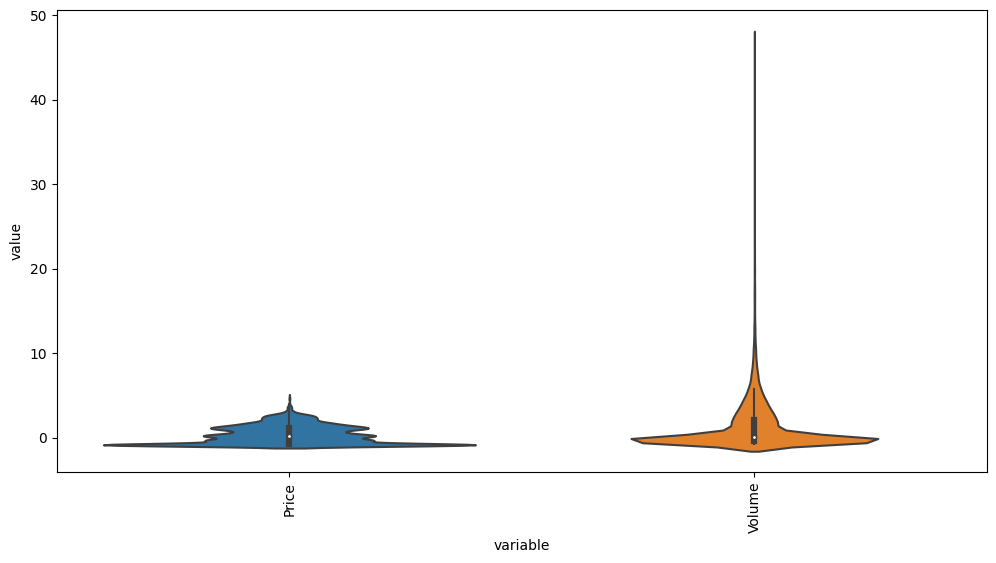

In [3]:
df_std2 = df2.with_columns([
    (pl.col(label) - train_mean2[label]) / train_std2[label] for label in train_mean2.columns
])
df_std2 = df_std2.melt(value_vars=df_std2.columns)
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='variable', y='value', data=df_std2.to_pandas())
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

In [6]:
window = WindowGenerator(input_width=10, label_width=10, shift=1, label_columns=['Price'], train_df=train_df, val_df=val_df, test_df=test_df)

window2 = WindowGenerator2(input_width=10, label_width=10, shift=1, label_columns=['Price'], train_df=train_df2, val_df=val_df2, test_df=test_df2)

window

NameError: name 'WindowGenerator' is not defined

In [ ]:
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)


In [ ]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

history = lstm_model.fit(window.train, epochs=20,
                         validation_data=window.val,
                         callbacks=[])

In [ ]:
IPython.display.clear_output()
val_performance_lstm = lstm_model.evaluate(window.val)
performance_lstm = lstm_model.evaluate(window.test, verbose=0)

In [ ]:
window.plot(lstm_model)